In [ ]:
import anndata as ad
import novaice
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
adata = ad.read_h5ad(
    "/Users/lucas-diedrich/Documents/Programming/nucleate-hackathon/nucleate-hackathon-2025/preprocessing/dataset-1/read_data/MCE_Bioactive_Compounds_HEK293T_10μM.h5ad"
)
adata

AnnData object with n_obs × n_vars = 40778 × 3407
    obs: 'unique_ID', 'experiment_no', 'sample_plate', 'sample_row', 'sample_column', 'cell_id', 'pert_itime', 'pert_idose', 'sample', 'treatment', 'Ranking', 'Catalog Number', 'Compound name', 'CAS Number', 'CID', 'CAS', 'smiles', 'sample_type', 'sample_streamlined'
    var: 'gene_name'
    uns: 'experiment_no_colors', 'log1p', 'neighbors', 'pca', 'pert_idose_colors', 'pert_itime_colors', 'sample_plate_colors', 'sample_type_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'foundation_embedding', 'morgan_fingerprint'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [ ]:
N = adata.n_obs  # or whatever your dataset length is
indices = np.arange(N)

training_compounds, testing_compounds = train_test_split(
    adata.obs["treatment"].unique(), test_size=0.2, random_state=42, shuffle=True
)

adata_train = adata[adata.obs["treatment"].isin(training_compounds)].copy()
adata_test = adata[adata.obs["treatment"].isin(testing_compounds)].copy()

In [ ]:
novaice.tl.ChemPertMLPModel.setup_anndata(
    adata=adata_train, drug_embedding_key="foundation_embedding", layer=None
)
model = novaice.tl.ChemPertMLPModel(adata=adata_train)

INFO     Generating sequential column names                                                                        


In [ ]:
model.train(
    train_size=0.8,
    early_stopping=True,
    early_stopping_monitor="reconstruction_loss_validation",
)

/Users/lucas-diedrich/mamba/envs/hackathon/lib/python3.12/site-packages/scvi/train/_trainrunner.py:84: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False


TPU available: False, using: 0 TPU cores
/Users/lucas-diedrich/mamba/envs/hackathon/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:166: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/lucas-diedrich/mamba/envs/hackathon/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/lucas-diedrich/mamba/envs/hackathon/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/lucas-diedrich/mamba/envs/hackathon/lib/python3.12/site-packages/lightning/pytorch/loops/fit

Training:   0%|          | 0/236 [00:00<?, ?it/s]

Monitored metric reconstruction_loss_validation did not improve in the last 45 records. Best score: 4917.454. Signaling Trainer to stop.


In [ ]:
model.history.keys()

dict_keys(['kl_weight', 'validation_loss', 'elbo_validation', 'reconstruction_loss_validation', 'kl_local_validation', 'kl_global_validation', 'train_loss', 'elbo_train', 'reconstruction_loss_train', 'kl_local_train', 'kl_global_train'])

<Axes: xlabel='epoch'>

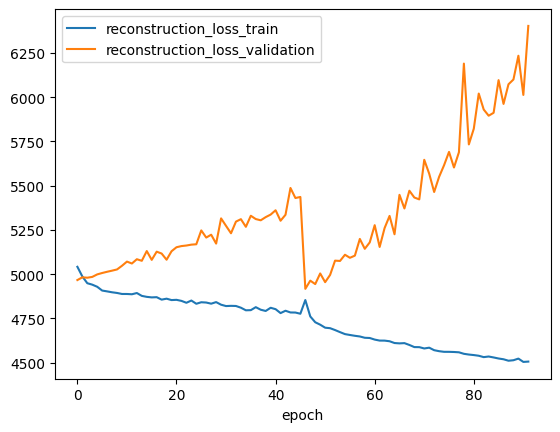

In [ ]:
fig, ax = plt.subplots(1, 1)
model.history["reconstruction_loss_train"].plot(ax=ax)
model.history["reconstruction_loss_validation"].plot(ax=ax)

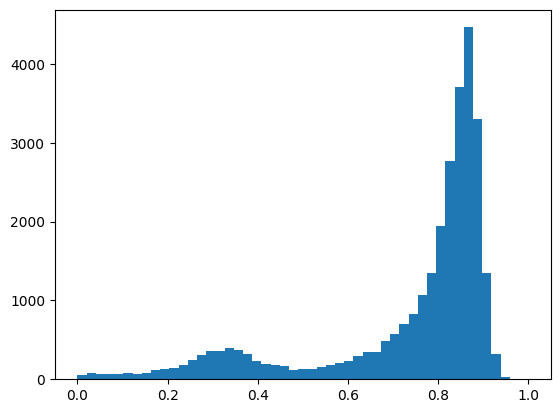

In [ ]:
r2 = model.get_prediction_error(method="r2")
plt.hist(r2, bins=np.linspace(0, 1, 50))
plt.show()

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


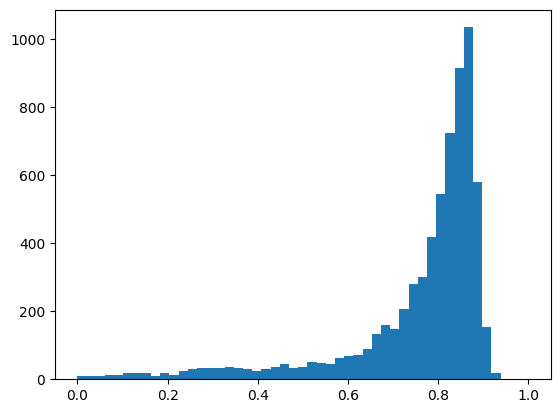

In [ ]:
r2_test = model.get_prediction_error(adata=adata_test, method="r2")
plt.hist(r2_test, bins=np.linspace(0, 1, 50))
plt.show()

In [ ]:
res = model.predict_gene_expression()
res

array([[ 5.3961807e-01,  8.9657586e-03,  6.7095327e+00, ...,
         5.0462160e+00,  4.0184622e+00,  3.8712184e+00],
       [ 5.5499923e-01,  1.6925585e-03,  6.5497999e+00, ...,
         4.9013071e+00,  3.6265316e+00,  3.1081710e+00],
       [ 5.5341625e-01, -6.3034527e-02,  6.8043652e+00, ...,
         5.1972666e+00,  4.1700172e+00,  3.6748166e+00],
       ...,
       [ 3.7251511e-01, -5.8685929e-02,  6.6916003e+00, ...,
         4.9499140e+00,  3.5910344e+00,  3.4953218e+00],
       [ 2.3393311e-01,  8.2112700e-03,  3.1030262e+00, ...,
         2.1909137e+00,  1.3722010e+00,  1.1843768e+00],
       [ 2.9934436e-01, -2.2839641e-02,  6.8841453e+00, ...,
         5.4403286e+00,  4.8349137e+00,  4.2879667e+00]],
      shape=(33959, 3407), dtype=float32)

In [ ]:
import pandas as pd

In [ ]:
r2 = model.get_prediction_error(method="r2")

In [ ]:
adata.obs

,unique_ID,experiment_no,sample_plate,sample_row,sample_column,cell_id,pert_itime,pert_idose,sample,treatment,Ranking,Catalog Number,Compound name,CAS Number,CID,CAS,smiles,sample_type,sample_streamlined
0,MCE5_293T_24H_X1:D10,MCE_20220606,MCE5_293T_24H_X1,4,10,cell_293T,24 h,10.0 uM,HY_50946,HY_50946,6471.0,HY_50946,Imatinib (Mesylate),220127-57-1,3427.0,220127-57-1,CC(=CCCC(=CCCC(=CCSC1=NC=NN1)C)C)C,compound,HY_50946
1,MCE5_293T_24H_X1:G14,MCE_20220606,MCE5_293T_24H_X1,7,14,cell_293T,24 h,10.0 uM,HY_18686,HY_18686,11581.0,HY_18686,AS1949490,1203680-76-5,44473434.0,1203680-76-5,C[C@@H](C1=CC=CC=C1)NC(=O)C2=C(C=CS2)OCC3=CC=C...,compound,HY_18686
2,MCE5_293T_24H_X1:G22,MCE_20220606,MCE5_293T_24H_X1,7,22,cell_293T,24 h,10.0 uM,HY_17592A,HY_17592A,10898.0,HY_17592A,Bithionol (sulfoxide),844-26-8,68939.0,844-26-8,C1=C(C=C(C(=C1S(=O)C2=C(C(=CC(=C2)Cl)Cl)O)O)Cl)Cl,compound,HY_17592A
3,MCE5_293T_24H_X1:O22,MCE_20220606,MCE5_293T_24H_X1,15,22,cell_293T,24 h,10.0 uM,HY_19411,HY_19411,290.0,HY_19411,SSR180711 (hydrochloride),446031-79-4,9928899.0,446031-79-4,C1CN2CCC1N(CC2)C(=O)OC3=CC=C(C=C3)Br.Cl,compound,HY_19411
4,MCE5_293T_24H_X1:G08,MCE_20220606,MCE5_293T_24H_X1,7,8,cell_293T,24 h,10.0 uM,HY_18522,HY_18522,8793.0,HY_18522,AA26-9,1312782-34-5,46829239.0,1312782-34-5,C1CCN(C1)C(=O)N2C=CN=N2,compound,HY_18522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40773,MCE4_293T_24H_X3:P01,MCE_20221009_3,MCE4_293T_24H_X3,16,1,cell_293T,24 h,-666,Blank_42,Blank,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Blank,Blank
40774,MCE4_293T_24H_X3:L21,MCE_20221009_3,MCE4_293T_24H_X3,12,21,cell_293T,24 h,10.0 uM,HY_13954,HY_13954,12102.0,HY_13954,A 839977,870061-27-1,53325875.0,870061-27-1,C1=CC=C(C(=C1)CNC2=NN=NN2C3=C(C(=CC=C3)Cl)Cl)O...,compound,HY_13954
40775,MCE4_293T_24H_X3:P13,MCE_20221009_3,MCE4_293T_24H_X3,16,13,cell_293T,24 h,10.0 uM,HY_15414,HY_15414,11846.0,HY_15414,Vortioxetine,508233-74-7,9966051.0,508233-74-7,CC1=CC(=C(C=C1)SC2=CC=CC=C2N3CCNCC3)C,compound,HY_15414
40776,MCE4_293T_24H_X3:J23,MCE_20221009_3,MCE4_293T_24H_X3,10,23,cell_293T,24 h,-666,DMSO_02,DMSO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DMSO,DMSO


In [ ]:
predicted = pd.DataFrame(
    model.predict_gene_expression(adata_test),
    index=model.adata.obs["treatment"],
    columns=model.adata.var_names,
)
predicted_long = predicted.reset_index().melt(
    id_vars="treatment", var_name="genes", value_name="value"
)

In [ ]:
measured = (
    adata_test.to_df()
    .set_index(adata_test.obs["treatment"])
    .reset_index(names="treatment")
    .melt(id_vars="treatment", var_name="genes", value_name="value")
)

In [ ]:
x = pd.DataFrame(r2_test, index=adata_test.obs["treatment"], columns=["r2"])
compounds = x[x["r2"].abs() < 0.2].index
compounds

CategoricalIndex(['HY_50895', 'HY_50946', 'HY_34477', 'HY_32329', 'HY_B0324A',
                  'HY_B1046', 'HY_B0192A', 'HY_B0168B', 'HY_U00058',
                  'HY_P0299A',
                  ...
                  'HY_129357', 'HY_13061', 'HY_13287', 'HY_122895A',
                  'HY_13634A', 'HY_15617', 'HY_15617', 'HY_15925', 'HY_15617',
                  'HY_131708A'],
                 categories=['HY_10007', 'HY_10008', 'HY_10009', 'HY_10043A', ..., 'HY_Y1819', 'HY_Z0478', 'HY_Z0548', 'HY_Z0816'], ordered=False, dtype='category', name='treatment', length=199)

In [ ]:
import pandas as pd

In [ ]:
deg = pd.read_parquet(
    "/Users/lucas-diedrich/Documents/Programming/nucleate-hackathon/nucleate-hackathon-2025/preprocessing/dataset-1/read_data/MCE_Bioactive_Compounds_HEK293T_10μM.deg.parquet"
)
deg

,group,names,scores,logfoldchanges,pvals,pvals_adj
0,Blank,TGFBI,0.315402,0.387819,7.524835e-01,7.535895e-01
1,Blank,CA4,0.000000,0.000000,1.000000e+00,1.000000e+00
2,Blank,PLA2G2A,0.000000,0.000000,1.000000e+00,1.000000e+00
3,Blank,SHH,0.000000,0.000000,1.000000e+00,1.000000e+00
4,Blank,ST8SIA6,0.000000,0.000000,1.000000e+00,1.000000e+00
...,...,...,...,...,...,...
38693294,HY_Z0816,PDK1,-32.811218,-32.265202,6.374044e-154,4.343273e-151
38693295,HY_Z0816,CD86,-32.823532,-32.308300,5.324195e-154,4.343273e-151
38693296,HY_Z0816,IGFBP5,-33.353111,-32.288464,2.337561e-157,2.654690e-154
38693297,HY_Z0816,XCL2,-34.503044,-32.386608,1.266685e-164,2.157798e-161


In [ ]:
deg_subset = deg[(~deg["group"].isin(compounds))]
deg_subset

,group,names,scores,logfoldchanges,pvals,pvals_adj
0,Blank,TGFBI,0.315402,0.387819,7.524835e-01,7.535895e-01
1,Blank,CA4,0.000000,0.000000,1.000000e+00,1.000000e+00
2,Blank,PLA2G2A,0.000000,0.000000,1.000000e+00,1.000000e+00
3,Blank,SHH,0.000000,0.000000,1.000000e+00,1.000000e+00
4,Blank,ST8SIA6,0.000000,0.000000,1.000000e+00,1.000000e+00
...,...,...,...,...,...,...
38693294,HY_Z0816,PDK1,-32.811218,-32.265202,6.374044e-154,4.343273e-151
38693295,HY_Z0816,CD86,-32.823532,-32.308300,5.324195e-154,4.343273e-151
38693296,HY_Z0816,IGFBP5,-33.353111,-32.288464,2.337561e-157,2.654690e-154
38693297,HY_Z0816,XCL2,-34.503044,-32.386608,1.266685e-164,2.157798e-161
